Import Modules

In [69]:
import numpy as np
import sep
import astropy
from astropy.io import fits

additional setup for reading the test image and displaying plots

In [70]:

import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.


In [71]:
data = fits.getdata("f105.fits")


Print Image

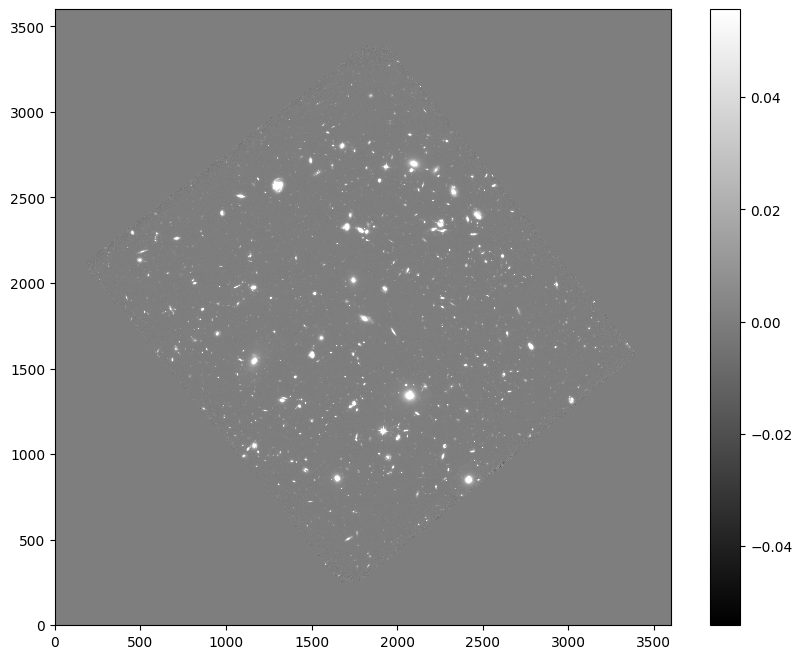

In [72]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('final1.png')

In [73]:
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [74]:
#get a 'global' mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


evaluate background as 2d array

In [75]:
bkg_image = bkg.back()

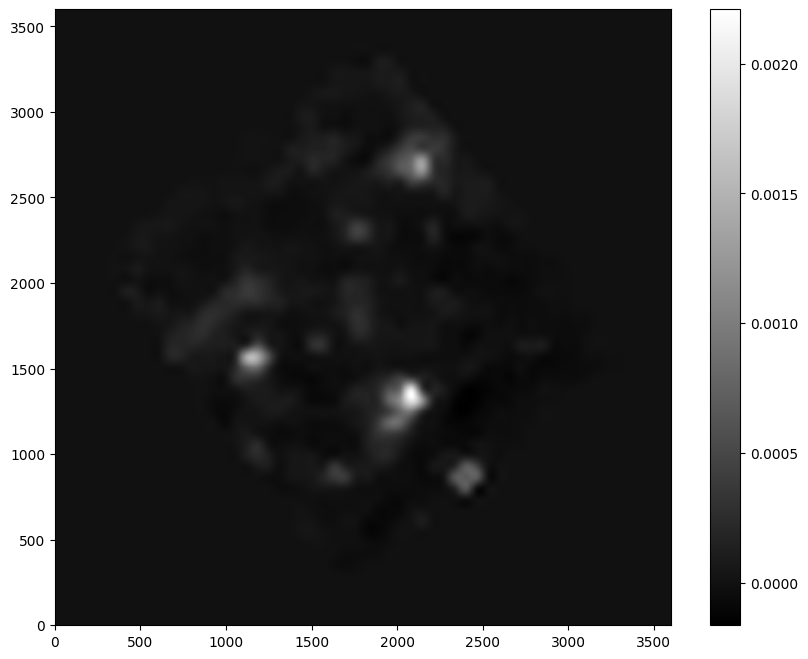

In [76]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('final2.png')

In [77]:
bkg_rms = bkg.rms()

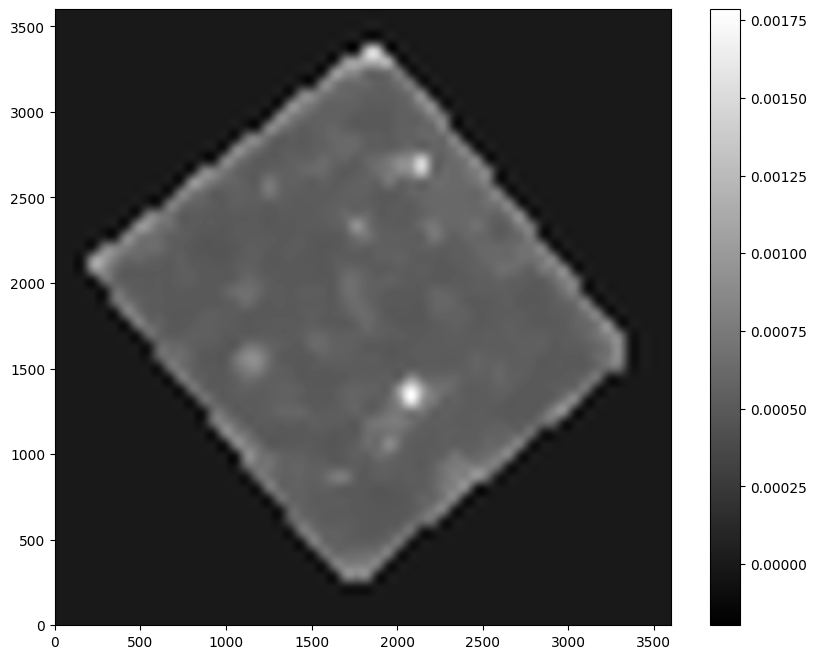

In [78]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('final3.png')

In [79]:
data_sub = data - bkg

Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 
1.5sigma where sigma is the global background RMS.



In [80]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

How many objects detected

In [81]:
len(objects)

8643

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

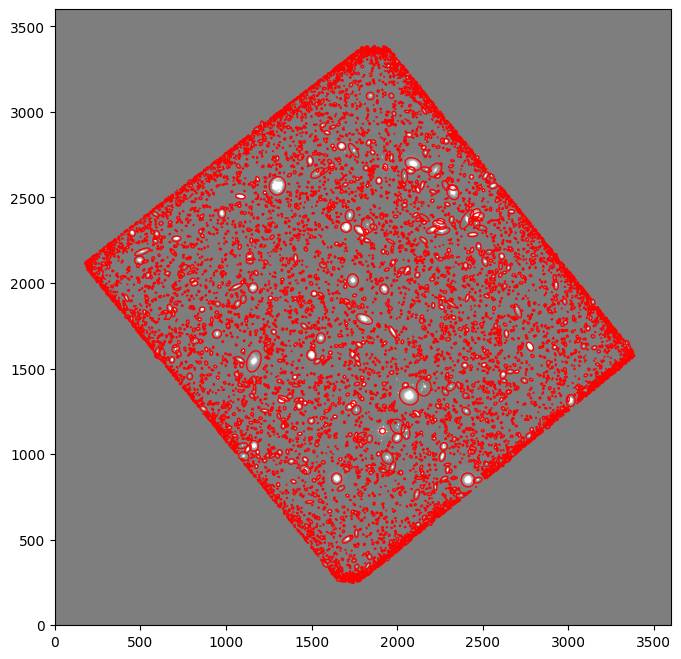

In [82]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s,origin='lower')

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
plt.savefig('final4.png')

You can see the available fields:

In [83]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [84]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

show the first 10 object results:

In [85]:
for i in range(10):
    print("object {:d} flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0 flux = 0.031282 +/- 0.176890
object 1 flux = 0.031018 +/- 0.176142
object 2 flux = -0.024388 +/- 0.002883
object 3 flux = 0.001947 +/- 0.044219
object 4 flux = 0.012457 +/- 0.111649
object 5 flux = -0.011228 +/- 0.002875
object 6 flux = 0.029368 +/- 0.171394
object 7 flux = -0.009126 +/- 0.002875
object 8 flux = 0.048023 +/- 0.219161
object 9 flux = 0.027840 +/- 0.166877


I found 8643 sources defined with the objects detected. 

Make histogram, with np nan code for std

/tmp/ipykernel_6457/2197111225.py:1: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(flux)


Standard deviation of fluxes: 1.4576671344484642
Mean of fluxes: 3.4028199700930553
Median of fluxes: 3.748300630568613
Outliers: [ 0.03128197  0.03101789 -0.02438809 ...  0.08851303  0.01802793
  0.01398957]


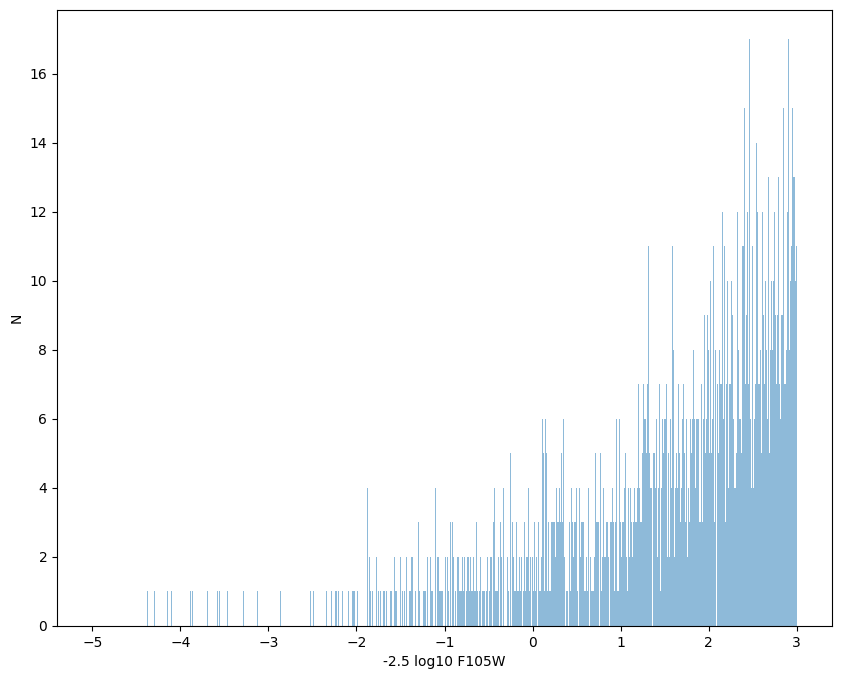

In [108]:
m = -2.5*np.log10(flux)
plt.hist(m, range=[-5,3],bins=1000,alpha=0.5) 
plt.xlabel('-2.5 log10 F105W') 
plt.ylabel('N')

print(f"Standard deviation of fluxes: {np.nanstd(m)}") 
print(f"Mean of fluxes: {np.nanmean(m)}") 
print(f"Median of fluxes: {np.nanmedian(m)}")

threshold = 2
outliers = flux[(np.abs(flux - np.nanmean(m)) > threshold * np.nanstd(m))]
print("Outliers:", outliers)

plt.savefig('histo.png')

The largest outlier is 0.08851303, it is 3 standard deviations away from the mean

make a 3-color false image of the UDF using RGB

Read in data:

In [87]:
f105w = fits.getdata('f105.fits')
f125w = fits.getdata('f125.fits')
f160w = fits.getdata('f160.fits')

Remove sky background for each image
Find medians after subtracting sky

In [88]:
median_f125w = np.nanmedian (f125w[f125w<1]) 
median_f105w = np.nanmedian (f105w[f105w<1]) 
median_f160w = np.nanmedian (f160w[f160w<1]) 
print(f'Median of f125w sky {median_f125w}') 
print(f'Median of f105w sky {median_f105w}') 
print(f'Median of f160w sky {median_f160w}') 

Median of f125w sky 0.0
Median of f105w sky 0.0
Median of f160w sky 0.0


In [89]:
f125w = f125w.byteswap().newbyteorder() 
f105w = f105w.byteswap().newbyteorder() 
f160w = f160w.byteswap().newbyteorder() 

bkg_f125w = sep. Background(f125w) 
bkg_f105w = sep. Background(f105w) 
bkg_f160w = sep. Background(f160w) 

f125w -= bkg_f125w
f105w -= bkg_f105w 
f160w -= bkg_f160w

In [90]:
data = data.byteswap().newbyteorder()
flux_f125w, fluxerr_f125w, flag_f125w = sep.sum_circle(f125w, objects ['x'], objects ['y'], 
                                                       3.0, err=bkg.globalrms, gain=1.0) 

In [91]:
flux_f105w, fluxerr_f105w, flag_f105w = sep.sum_circle(f105w, objects ['x'], objects['y'], 
                                                       3.0, err=bkg.globalrms, gain=1.0)

In [92]:

objects = sep.extract(f160w,5,err=bkg_f160w.globalrms)
flux_f160w, fluxerr_f160w, flag_f160w = sep.sum_circle(f160w, objects ['x'], objects['y'], 
                                                       3.0, err=bkg_f160w.globalrms, gain=1.0) 

rescale data

In [93]:
def rescale_data(data,dmin=0.0001,dmax=0.5): 
    datac = np.clip(data,dmin,dmax) 
    return (np.log10(datac)-np.log10(dmin))/(np.log10(dmax)-np.log10(dmin))

In [94]:
p_f125w = rescale_data(f125w)
p_f105w = rescale_data(f105w)
p_f160w = rescale_data(f160w)

make RGB stack of data

In [95]:
rgb = np.stack([p_f160w,0.7*p_f125w,p_f105w],axis=-1)

print(rgb.shape)

(3600, 3600, 3)


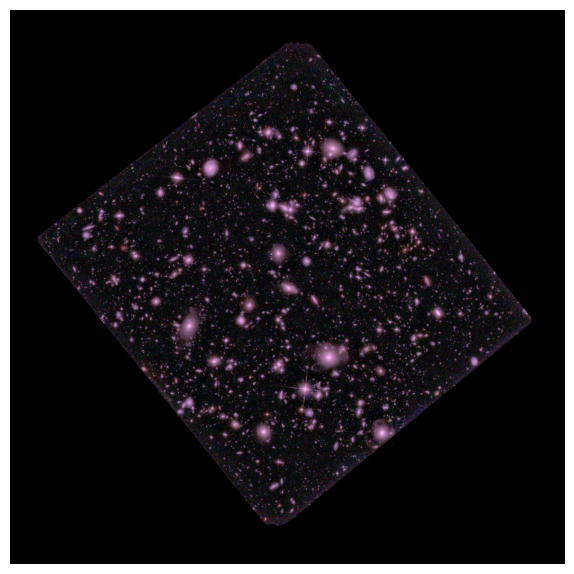

In [96]:
xsize = rgb.shape[1] 
ysize = rgb.shape[0] 

f,ax = plt.subplots (1,1,figsize=(2*xsize/1000.,2*ysize/1000.0)) 
ax.axis('off') 
ax.imshow(rgb,origin='lower')
plt.savefig('rgb.png')